#  Design of Complex Neuroscience Experiments using Mixed Integer Linear Programming
This notebook provides example implementations for the four case studies in the article ["Design of Complex Experiments using Mixed Integer Linear Programming"](https://arxiv.org/abs/2012.02361). Each case study aims to demonstrate how Mixed Integer Linear Programming (MILP) can be used to address real-world experimental design challenges. This notebook reproduces the figures related to each case study. Full details of each case study can be found in the main article. The article also contains an introduction to the mathematical foundations of MILP.

## Code Organization


### The `milp` Package

For clarity, some code has been has been omitted from this notebook and placed in the `milp` python package. This includes code related to solving each program and visualizing each program solution. The `milp` package can be found in the root directory of this repository and can be installed using the included `setup.py` file.

### The `milp` Workflow

Each example is solved by creating mixed integer linear programs. Each mixed integer linear program is constructed using the same basic workflow:

#### 1. Initialize Program
`milp.program.initialize_program()` initializes a dictionary that represents a mixed integer linear program. This dictionary will be updated to include the program's variables, linear constraints, and cost function terms.

```python
import milp
program = milp.program.initialize_program()```

#### 2. Add Variables

`milp.program.add_variable()` adds a variable to a program. The name given to each variable will be used to specify its constraints and cost function coefficients. Whether a varaible is real, integer, or boolean can be specified by setting `variable_type` to `float`, `int`, or `bool`.

```python
milp.program.add_variable(
    program=program,
    name='a',
    variable_type=bool,
)
milp.program.add_variable(
    program=program,
    name='b',
    variable_type=int,
    lower_bound=float('-inf'),
    upper_bound=float('inf'),
)
milp.program.add_variable(
    program=program,
    name='c',
    variable_type=float,
)
```

#### 3.  Add Linear Constraints

`milp.program.add_constraint()` adds a linear constraint to program. An equality constraint can be specified by using arguments `A_eq` and `b_eq`. The value of `A_eq` should be a dictionary whose keys are variable names and whose values are coefficients of those variables. Inequality constraints can be specified by using `A_lt` and `b_lt`. 

```python
milp.program.add_constraint(
    program=program,
    A_eq={'a': 1, 'b': 1},
    b_eq=0,
)
milp.program.add_constraint(
    program=program,
    A_lt={'a': 1, 'b': 2, 'c': 3},
    b_lt=3,
)
```

#### 4. Specify Cost Function
`milp.program.add_cost_terms` is used to specify the program's cost function. The value of `coefficients` should be a dictionary whose keys are variable names and whose values are coefficients of those variables.

```python
milp.program.add_cost_terms(
    program=program,
    coefficients={'a': -1, 'b': 1},
)
```

#### 5. Solve Program
`milp.program.solve_program()` solves the program using an external library (by default uses [Gurobi](https://www.gurobi.com)). It does this by 1) converting the program into the library-compatible representation, 2) running its solver, and 3) returning the solution. This solution specifies an experimental design that optimally conforms to the design constraints of the program.

```python
solution = milp.program.solve_MILP(program=program)
print(solution['variables'])
```
```> {'a': True, 'b': -1, 'c': 0.0}
```

Taken together these code snippets have represented and solved the following simple program:
$$
\min{b - a} \\
a + b = 0 \\
a + 2 b + 3 c \leq 3 \\
\\
a \in \mathbb{B}, b \in \mathbb{Z}, c \in \mathbb{R}^+
$$

Some additional functions are used to implement the design patterns discussed in **Section 3.2** of the main article. For further details refer to the source code and docstrings of `milp`.


## Software Licensing
- All code in this repository, including the code in the `milp` package and the code in this Jupyter notebook, is licensed under a BSD 2-clause license.
- By default the `milp` package solves programs using the external library [Gurobi](https://www.gurobi.com). Gurobi offers free academic licenses, available [here](https://www.gurobi.com/downloads/end-user-license-agreement-academic/). Instructions for installing Gurobi can be found on the Gurobi website.
- Alternative solvers can be used instead of Gurobi. The `milp` also contains an adapter for [CPLEX](https://www.ibm.com/analytics/cplex-optimizer), used by specifying `solve_MILP(..., solver='cplex')`.

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

import milp
from milp.examples import balanced_grouping
from milp.examples import stimulus_task_pairing
from milp.examples import structured_sampling
from milp.examples import trajectory_design

In [2]:
# setup plot formatting

%matplotlib inline

milp.formatting.setup_plot_formatting()

In [3]:
# initialize software license

milp.program.initialize_license()

Using license file /home/jlg/storm/bin/gurobi902/gurobi.lic
Academic license - for non-commercial use only


# Example Problem 1: Balanced Grouping

A common challenge when designing experiments is to distribute conditions across blocks or sessions in a balanced way. Perhaps a researcher requires that each block of the experiment must have a similar number of exemplars of some stimulus category. Perhaps a researcher must collect data on a large battery of tasks, and the task distribution should be similar across each scanning session. Perhaps a researcher needs to evenly distribute content across trials, blocks, and sessions simultaneously. All of these scenarios can be addressed by MILP in a similar manner.

### Design Specifications

In this first example we will cover the simple case of trying to balance the mean luminance of visual stimuli across scanning runs. Suppose a researcher is designing a vision study using 360 short videos. Each video is 20 seconds long and has its own mean luminance. For data collection, the videos must be grouped into 12 separate runs of 10 minutes each, with each video appearing in exactly one run. Importantly, the researcher plans to perform an analysis that requires all of the runs to have the same mean luminance. Although this may seem like a trivial requirement, it can be extremely challenging in practice. There are 10^367 possible groupings that split 360 items into 12 equally sized groups. This space is far too large to test every possible grouping. The solution space is also discrete, so gradient-based methods cannot be used. **Figure 2B** shows a synthetic distribution of luminances that we have created for the videos.

### MILP Formulation

It is straightforward to express this problem as a mixed integer linear program. For notation, let $V$ be the number of videos, $R$ be the number of runs, $v$ be the index over videos, and $r$ be the index over runs. The first step is to define the variables of the solution space. Introduce binary variables $X$ to represent possible pairings between runs and videos:

> **VARIABLES**
$$X \in \mathbb{B}^{V \times R} \\$$
$$\begin{aligned}
x_{v,r} &= 1 \rightarrow \text{ video } v \text{ is in run } r \\
        &= 0 \rightarrow \text{ video }v \text{ is not in run } r
\end{aligned}$$


All of the desired grouping properties in this problem can be expressed as linear equalities over elements of $X$. To specify that each run must contain $V / R = 30$ videos, introduce a constraint for each run:

> **CONSTRAINTS**
$$\sum_v x_{v,r} = 30 \quad \forall \ r \in \{1, ..., R\}$$

To specify that each video appears in exactly one run, introduce a constraint for each video:

> **CONSTRAINTS**
$$\sum_r x_{v,r} = 1 \quad \forall \ v \in \{1, ..., V\}$$

Any value of $X$ that satisfies all of the above constraints is a feasible grouping that produces a valid experiment.

A cost function can now be designed to select the experiment that best balances luminance. Assume that the mean luminance of each video is stored in a vector $f$. This vector is predetermined by the video dataset. Use a cost function that is the sum of absolute deviations between the global mean and the mean of each run.


> **COST FUNCTION**
$$\begin{aligned}
\mu &= \frac{1}{V} \sum_{v} f_v \\
&= \text{mean luminance across all videos} \\
\mu_r &= \frac{R}{V} \sum_v f_v \ x_{v,r} \\
&= \text{mean luminance within run } r \\
\end{aligned}
$$
$$ $$
$$\min \sum_r | \mu - \mu_r |$$

In [4]:
def create_group_balance_problem(I, G, F):
    """create program to solve group balance problem
    
    ## Parameters
    - I: int number of items
    - G: int number of groups
    - F: (n_features, I)-shaped array of features
    """

    s = int(I / float(G))
    if s * G != I:
        raise Exception('G does not evenly divide I')
    
    program = milp.program.initialize_program()

    # decision variables
    for i in range(I):
        for g in range(G):
            milp.program.add_variable(
                program=program,
                name='X_{i},{g}'.format(i=i, g=g),
                variable_type=bool,
            )

    # each item should be placed in one group
    for i in range(I):
        coefficients = {'X_{i},{g}'.format(i=i, g=g): 1 for g in range(G)}
        milp.program.add_constraint(program, A_eq=coefficients, b_eq=1)

    # groups should have sizes  s1, ..., sg
    for g in range(G):
        coefficients = {'X_{i},{g}'.format(i=i, g=g): 1 for i in range(I)}
        milp.program.add_constraint(program, A_eq=coefficients, b_eq=s)

    # mean group features
    for f in range(F.shape[0]):
        for g in range(G):
            m_name = 'm_{f},{g}'.format(f=f, g=g)
            milp.program.add_variable(
                program=program,
                name=m_name,
                variable_type=float,
            )
            coefficients = {
                'X_{i},{g}'.format(i=i, g=g): F[f, i]
                for i in range(I)
            }
            coefficients[m_name] = -s
            milp.program.add_constraint(
                program=program,
                A_eq=coefficients,
                b_eq=0,
            )

    # global means
    global_means = []
    for f in range(F.shape[0]):
        global_mean = (1 / float(I)) * sum(F[f, i] for i in range(I))
        global_means.append(global_mean)
        milp.program.store_constant(
            program,
            'global_feature_mean_' + str(f), global_means[-1],
        )

    # balance terms in cost function
    for f in range(F.shape[0]):
        for g in range(G):
            coefficients = {'m_{f},{g}'.format(f=f, g=g): 1}
            milp.program.add_abs_cost_term(
                program=program,
                coefficients=coefficients,
                constant=-global_means[f],
            )
    
    return program

### create program

In [5]:
np.random.seed(0)

I = 360
G = 12
n_f = 1

# power distribution
F = np.zeros([n_f, I])
F[0, :] = 1 - np.random.power(3, size=(I))

F = (F * 1000)
F_reduce = F.astype(int)

program = create_group_balance_problem(
    I=I,
    G=G,
    F=F_reduce,
)

### solve program

In [6]:
solution = milp.program.solve_MILP(program)

X_solution = milp.program.get_solution_variable(solution, 'X')
m_solution = milp.program.get_solution_variable(solution, 'm')
global_feature_mean = milp.program.get_solution_constant(
    solution,
    'global_feature_mean',
)

print()
print('X_solution', X_solution.shape)

program size:
- n_variables: 4344
- n_constraints: 408
- n_cost_function_terms: 12

X_solution (360, 12)


### find randomized solutions

In [7]:
# n = 1e6
n = 1e8

X_solution = X_solution.T.copy().T
balanced_grouping.set_comparison_context(F, X_solution, F.mean(1))
best_randomization = balanced_grouping.compute_randomization_solutions(
    F,
    n,
    processes=20,
)
randomization_ds = best_randomization['randomization_ds']

### visualize result

Figure 2B:


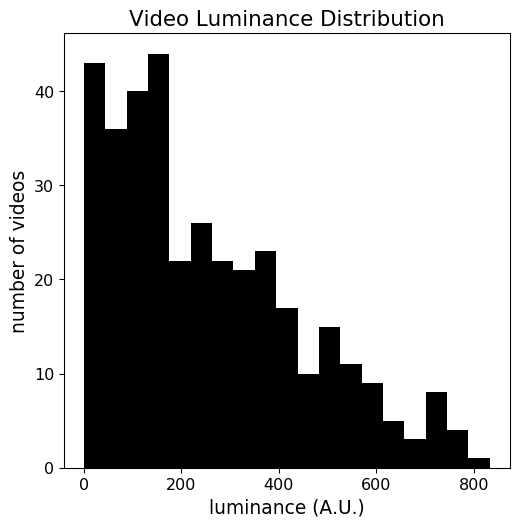

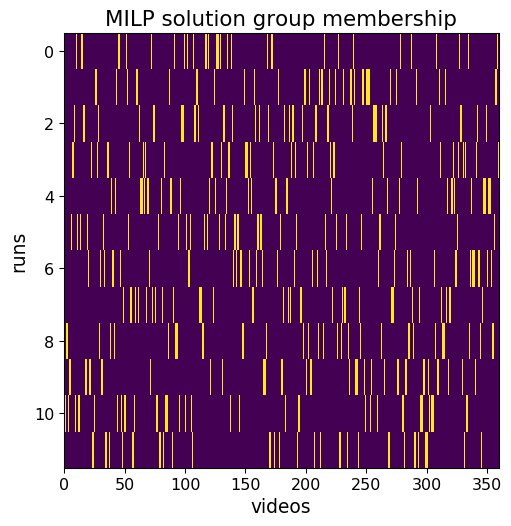

Figure 2C:


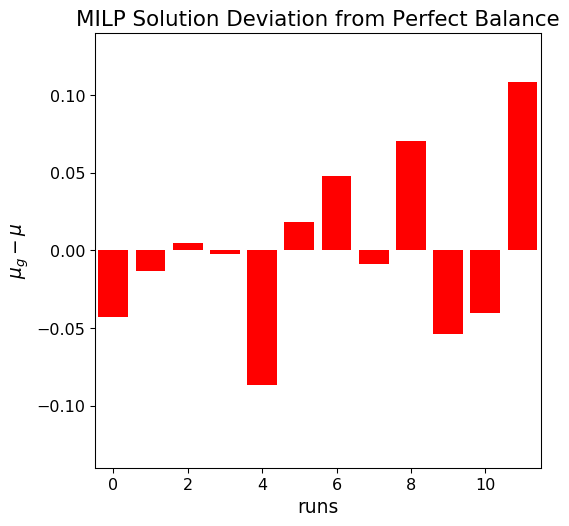

Figure 2D:


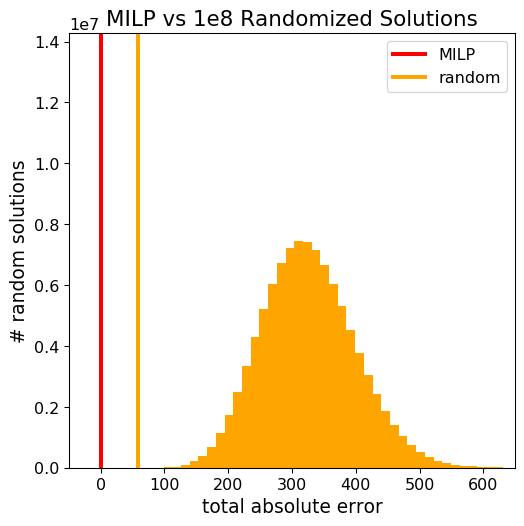

In [8]:
balanced_grouping.plot_grouping_separate_plots(
    F,
    X_solution,
    randomization_ds,
    n=n,
    figsize=[6, 6],
    randomization_axis=[-50, 650, 0, n / 7.0],
    show_title=True,
    show_labels=True,
    show_legend=True,
)

### How much better is MILP?

In [9]:
X_groups = [np.nonzero(X_solution[:, g])[0] for g in range(G)]
global_feature_means = F.mean(1)
group_evaluation = balanced_grouping.evaluate_groups(
    X_groups,
    F,
    global_feature_means
)
d_milp = group_evaluation['d_total']
ratio = best_randomization['d'] / d_milp
print(
    'the MILP solution has',
    ratio,
    'times smaller error than the best randomized solution',
)

the MILP solution has 116.23892083863578 times smaller error than the best randomized solution


**Figure 2C** and **Figure 2D** show a solution to this program. As guaranteed by the MILP solver, this solution achieves the lowest cost function value of any X in the feasible set. **Figure 2C** shows the degree to which the mean luminance of each run deviates from the global mean luminance. This value is small compared to the overall range of luminances. **Figure 2D** compares the solution found using MILP to 108 solutions found using randomization. Each randomization solution is generated by simply shuffling the videos and then splitting into 12 sequential groups. The graph shows that the solution found using MILP is substantially more balanced than any solution that can be found by randomization. The best randomized solution is the one with the lowest total balance error. As shown in in Figure 2D, the best randomized solution still has a total balance error that is 116 times larger than the solution found using MILP. 

# Example Problem 2: Stimulus-Task Pairing


Another common neuroimaging challenge is designing top-down attention experiments. In these studies, the subject’s attention state is varied systematically to demonstrate the effect of attention on brain activity. If similar stimuli are presented during each attention condition, then attention is assumed to be the operative factor underlying any differences in brain activity.

Visual attention experiments are typically limited to a small number of attention conditions. Each additional condition requires more data to be collected and also adds complexity to the overall design. Each attention condition in an experiment might also have its own idiosyncratic requirements. For example, some visual tasks (e.g. object identification) can only be performed on certain types of images (e.g. images containing objects). These experiments must be carefully balanced to ensure that the only meaningful difference across each condition is the subject's attentional state. 

In this case study, we demonstrate how MILP can address these challenges to create designs that have large numbers of attention conditions. Suppose a researcher is designing a visual attention experiment in a manner similar to (Clark et al. 1997), (O'Craven et al. 1999), or (Harel et al. 2014). In each of these studies, the subject’s attention state is varied independently from a visual stimulus to demonstrate the effect of attention on brain activity. These studies used 2, 3, and 6 attention states, respectively. For this example, suppose the researcher would like to significantly increase the number of attention conditions in an attempt to build a richer and more complete model of how attention affects brain activity.

### Design Specifications

The researcher would like the experiment to consist of many individual trials. During each trial, the subject will first be cued with a visual search target, such as an object category, a scene category, or a color. Then, an image will briefly flash. Finally, the subject will have a response period to indicate whether they detected the search target in the image. The researcher has allotted time for 2800 trials evenly split across 14 different search conditions, resulting in 200 trials per condition.

The researcher has a stimulus dataset of 700 images. Each trial will use one of these images. Each of the images has been labeled along each of the 14 different search dimensions with one of three values. A “0” indicates that the image definitely does not contain the search target, a “1” indicates that the image might contain the search target, and a “2” indicates that the image definitely contains the search target. For this example we will create a synthetic dataset of image labels generated from a multinomial distribution where feature values [0, 1, 2] have probabilities [0.5, 0.25, 0.25].

The main challenge that the researcher faces is deciding which images to use with each attention condition. There are three different types of balance that the researcher would like to impose. First, to reduce the effect of the subject memorizing the images, the researcher would like each image to appear in an equal number of trials throughout the experiment. This results in 4 trials per image (= 2800 trials / 700 images). Each image should also be paired with each attention condition no more than once. Second, the researcher would like to control for the effects of target detection (Guo et al. 2012; Çukur et al. 2013). To this end, the trials within each task should be evenly balanced across the 3 detection levels, meaning that ⅓ of trials should definitely contain the search target, ⅓ should ambiguously contain the search target, and ⅓ should definitely not contain the search target. Finally, to ensure that the stimulus feature distributions are similar across tasks, the researcher would like the feature distribution of each task to resemble the global feature distribution. More specifically, the mean value of each of the 14 features should be approximately equal across conditions.

### MILP Formulation

This problem can be seen as a variant of the previous balanced grouping problem in **Section 4.1** where the groups are now task conditions rather than runs. The main differences are that: 1) each group has its own unique constraints, 2) stimuli are allowed to appear in more than 1 group, and 3) multiple features are being balanced across groups.

Use $i$ to index images, $t$ to index tasks, and $f$ to index stimulus features. The main variable of interest is the pairing of stimuli with tasks. Introduce binary variables $X$ to represent these pairings:

> **VARIABLES**
$$X \in \mathbb{B}^{700 \times 14} \\$$
$$\begin{aligned}
x_{i,t} &= 1 \rightarrow \text{ image } i \text{ is paired with task } t \\
        &= 0 \rightarrow \text{ image } i \text{ is not paired with task } t
\end{aligned}$$


It is simple to constrain each task to have the same number of trials (2800 / 14 = 200)

> **CONSTRAINTS**
$$\sum_i x_{i,t} = 200 \quad \quad \quad \forall \ t \in \{ 1, ..., 14 \}$$

It is also simple to require that all images appear an equal number of times throughout the experiment. For 2800 trials and 700 images, each image should be used 2800 / 700 = 4 times.

> **CONSTRAINTS**
$$\sum_t x_{i,t} = 4 \quad \quad \quad \forall \ i \in \{ 1, ..., 700 \}$$

For each task, there should be an equal number of trials where the search target is present, ambiguous, or absent. Thus each of these three feature levels should have 200 × ⅓ = 66.67 trials. Since this is not an integer, constraints can be constructed using the integral floor and ceiling of this number. Let $S_{t,v}$ be the set of stimulus indices that have feature value $v$ for task $t$.

> **CONSTRAINTS**
$$\begin{aligned}
\sum_{i \in S_{t,v}} x_{i,t} \ge 66 \quad \quad \quad & \forall \ t \in \{1, ..., 14\} \text{ and } v \in \{ 1, 2, 3 \} \\
\sum_{i \in S_{t,v}} x_{i,t} \le 67 \quad \quad \quad & \forall \ t \in \{1, ..., 14\} \text{ and } v \in \{ 1, 2, 3 \}
\end{aligned}
$$

The final part of the program is a cost function that promotes a similar stimulus feature distribution within each task. Use a matrix $L$ to refer to the feature values of each stimulus, where $L_{i,t}$ is the value of feature $t$ for image $i$. Also, let $μ_f$ be the global mean value of feature $f$ across all images. $L$ and $μ_f$ are constants predetermined by the image dataset. Use a cost function that minimizes the deviations between the global feature means $μ_f$ and the feature means of each task $m_{f,t}$.

> **COST FUNCTION**
$$\begin{aligned}
m_{f,t} &= \frac{1}{200} \sum_i x_{i,t}\ L_{i,f} \\
        &= \text{mean value of feature } f \text{ across trials of task } t
\end{aligned}$$
$$\\$$
$$\min \sum_{f,t \atop {f \neq t}} | m_{f,t} - \mu_f |$$

In [10]:
def create_stimulus_condition_pairing_problem(
    n_trials,
    L,
    feature_probabilities,
):
    """create program to solve stimulus condition pairing problem
    
    ## Parameters
    - n_trials: int number of items
    - L: (n_features, n_images)-shaped array of stimulus tags
    - feature_probabilities: dict of probably for each detection level
    """
    n_features, n_stimuli = L.shape
    n_tasks = n_features
    
    program = milp.program.initialize_program()

    # decision variables
    for i in range(n_stimuli):
        for g in range(n_tasks):
            milp.program.add_variable(
                program,
                'X_{i},{g}'.format(i=i, g=g),
                variable_type=bool,
            )

    trials_per_condition = int(n_trials / n_tasks)
    assert trials_per_condition * n_tasks == n_trials

    # constraint: match feature probabilities
    for g in range(n_tasks):
        for feature_value, feature_probability in feature_probabilities.items():
            
            feature_count = feature_probability * trials_per_condition
            
            variables_of_feature_value = {}
            for i in range(n_stimuli):
                if L[g, i] == feature_value:
                    variables_of_feature_value['X_{i},{g}'.format(i=i, g=g)] = 1

            mode = 'ceil_floor'
            if mode == 'exact':

                assert feature_count == int(feature_count)
                milp.program.add_constraint(
                    program,
                    A_eq=variables_of_feature_value,
                    b_eq=feature_count,
                )
            
            elif mode == 'ceil_floor':
            
                ceil = int(np.ceil(feature_count))
                floor = int(np.floor(feature_count))

                milp.program.add_constraint(
                    program,
                    A_lt=variables_of_feature_value,
                    b_lt=ceil,
                )
                milp.program.add_constraint(
                    program,
                    A_lt={k: -v for k, v in variables_of_feature_value.items()},
                    b_lt=-floor,
                )
            
            else:
                raise Exception(mode)
    
    # hard constrain equal usages per stimulus
    target_stimulus_repeats = (n_trials / float(n_stimuli))
    milp.program.store_constant(
        program=program,
        name='target_stimulus_repeats',
        value=target_stimulus_repeats,
    )
    for i in range(n_stimuli):
        coefficients = {}
        for g in range(n_tasks):
            coefficients['X_{i},{g}'.format(i=i, g=g)] = 1
        milp.program.add_constraint(
            program,
            A_eq=coefficients,
            b_eq=target_stimulus_repeats,
        )

    # for each task, balance the feature distributions to the population mean
    for g in range(n_tasks):
        for f in range(n_features):
            if g == f:
                continue

            coefficients = {}
            for i in range(n_stimuli):
                coefficients['X_{i},{g}'.format(i=i, g=g)] = L[f, i]

            milp.program.add_abs_cost_term(
                program,
                coefficients=coefficients,
                constant=-trials_per_condition * L[f, :].mean(),
            )

    return program

In [11]:
np.random.seed(0)

n_tasks = 14
n_stimuli = 700
n_trials = 2800

F_feature_values = [0, 1, 2]
F_feature_probabilities = [0.5, 0.25, 0.25]

L = np.random.choice(
    F_feature_values,
    p=np.array(F_feature_probabilities),
    size=(n_tasks, n_stimuli),
)

n_feature_values = len(F_feature_values)
feature_probabilities = {
    F_feature_values[i]: 1.0 / n_feature_values
    for i in range(n_feature_values)
}

program = create_stimulus_condition_pairing_problem(
    n_trials=n_trials,
    L=L,
    feature_probabilities=feature_probabilities,
)

### solve program

In [12]:
solution = milp.program.solve_MILP(program)
X_solution = milp.program.get_solution_variable(solution, 'X')

print()
print('X_solution', X_solution.shape)

program size:
- n_variables: 9982
- n_constraints: 1148
- n_cost_function_terms: 182

X_solution (700, 14)


### visualize result

MILP solution


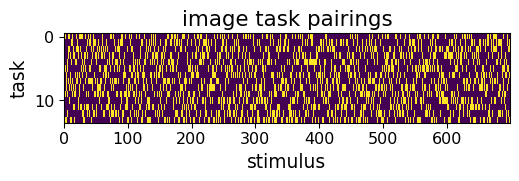

Figure 3B:


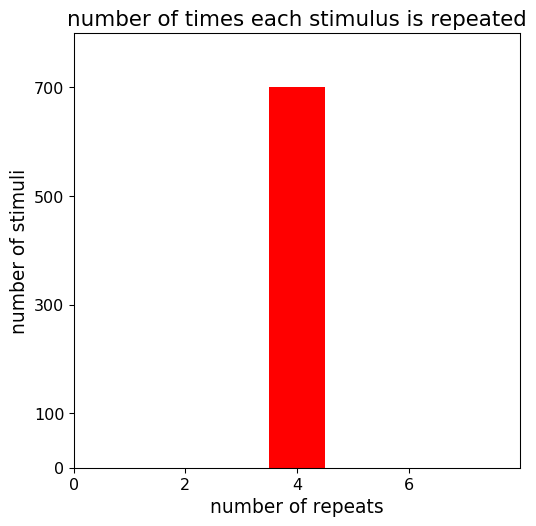

Figure 3C:


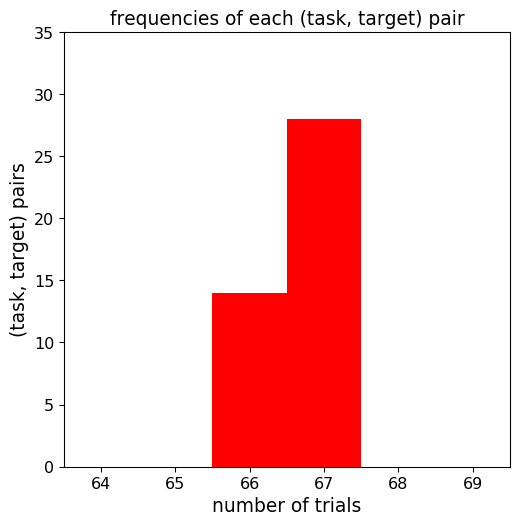

Figure 3D:


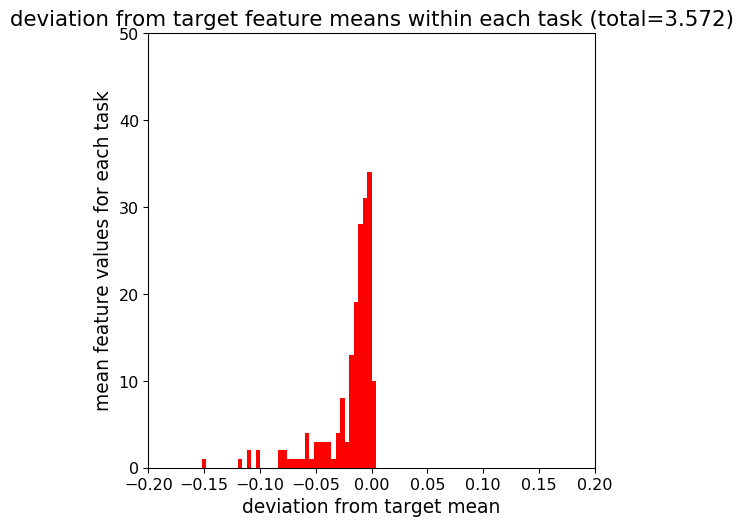

In [13]:
print('MILP solution')
stimulus_task_pairing.plot_as_separate_figures(
    X_solution,
    L,
    figsize=[6, 6],
    show_title=True,
    show_labels=True,
)

# Example Problem 3: Structured Hierarchical Sampling

Another common neuroimaging design challenge is sampling stimuli from a highly structured space, such as the space of natural language. Such spaces are difficult to sample because samples must obey strict rules rather than being drawn from a simple probability distribution. Natural language stimuli cannot be generated by simply combining random words. For language to be intelligible, words must be jointly compatible in a meaningful way, obeying rules of grammar, syntax, and semantics. To sample from this type of space, one must be able to efficiently represent and navigate the rules of the space.

In this example, suppose a researcher would like to generate natural language stimuli in the form of questions about concrete nouns. These questions will be used in an experiment that asks a large number of questions about a large number of concrete nouns, in a manner similar to (Sudre et al. 2012). In this previous study, the authors asked 20 questions about each of 60 nouns in approximately 1 hour of scanning time. In this example we will use a sparse sampling strategy to increase the scope of this experiment to 5x the number of nouns and 6x the number of questions while only using 2x the trials. We will also allow the researcher to specify rules about which nouns are semantically compatible with each question.

Questions are formed by pairing a single concrete noun (e.g. a car, a phone, a flower) with a question template (e.g. How heavy is <X>? When was <X> invented? What color is <X>?). Concrete nouns are organized into a semantic hierarchy (**Figure 4B**). Unlike the (Sudre et al. 2012) study, each question template is only applicable to nouns from a particular portion of this hierarchy (**Figure 4C**). For example, questions related to object affordances might only be compatible with nouns from the “Inanimate Object” portion of the tree. Questions related to social behavior might only be compatible with the “People” portion of the tree. The researcher would like to independently model the effects of questions and concrete nouns. To this end they will place constraints on how often each is sampled, and the manner in which they are allowed to combine.

### Design Specifications

In this example the researcher has allotted scanning time for 2400 trials. There are a total of 300 concrete nouns organized into a 15-group semantic hierarchy shown in **Figure 4B**. Each concrete noun exists in exactly one of the 10 leaf groups, and each leaf group contains exactly 30 concrete nouns. For each of the 15 example groups shown, the researcher has 8 question templates, for a total of 120 question templates. Each question template is applicable to some subset of the semantic hierarchy. Question templates related to a non-leaf group are compatible with any nouns for which that non-leaf group is an ancestor.

The main challenge that the researcher faces is deciding which concrete nouns to pair with each question template. Each noun should be paired with each question template no more than 1 time, and all pairings should respect the compatibility constraints of the semantic hierarchy. Each of the 120 question templates should be used the same number of times across the 2400 trials. Because each noun is compatible with a different number of question templates, it is not possible to exactly balance the number of times each concrete noun is used. However, noun usage should still be balanced as much as possible. Finally, for question templates that are compatible with multiple leaf groups in the semantic hierarchy, the researcher would like to balance the number of times each template is paired with each compatible leaf group.

### MILP Formulation

Index question templates with $t$, concrete nouns with $n$, and noun leaf groups with $g$. Store information about template-group compatibility in a matrix $C$

>$$C \in \mathbb{B} ^ {120  \times 10} \\$$
$$\begin{aligned}
c_{t, g} &= 1 \rightarrow \text{ question template } t \text{ compatible with group } g \\
&= 0 \rightarrow \text{ question template } t \text{ not compatible with group } g
\end{aligned}$$

Store information about noun-group membership in a matrix M

> $$M \in \mathbb{B} ^ {10 \times 300} \\$$
$$\begin{aligned}
m_{g, n} &= 1 \rightarrow \text{ noun } n \text{ is in group } g \\
         &= 0 \rightarrow \text{ noun } n \text{ is not in group } g
\end{aligned}$$

Matrices $C$ and $M$ are constants that are predetermined by the given semantic tree.

The main variables to be decided are pairings between question templates and concrete nouns. Introduce variables $P$ to represent these pairings

> **VARIABLES**
            
$$P \in \mathbb{B} ^ {120  \times 300} $$

$$\begin{aligned}
p_{t,n} &= 1 \rightarrow \text{ question } t \text{ is paired with noun } n \\
        &= 0 \rightarrow \text{ question } t \text{ is not paired with noun } n
\end{aligned}$$

Pairs $(t, n)$ for which $(CM)_{t,n} = 0$ are invalid pairings. The corresponding $p_{t,n}$ variables can be set to $0$ to reduce the size of the program. Each question template should be used 2400 / 120 = 20 times

> **CONSTRAINT**
$$\sum_n p_{t,n} = 20 \quad \forall \ t \in \{1, ..., 20 \}$$

The next step is to balance the number of times that each question template is paired with each of its compatible noun groups. The number of times that template $t$ is paired with group $g$ is given by an element of the matrix product $(PMT)_{t,g}$. Let $v_t$ be  the number of noun groups that are compatible with template $t$. Since each question template is to be used 20 times, each question template $t$ should be used $(20 / v_t)$ times with each of its compatible noun groups. Since this quotient is not necessarily integral, $(PMT)_{t,g}$ can be constrained to fall within its integral floor and ceiling.

> **CONSTRAINT**
$$v_t = \sum_g c_{t,g} \\ \\$$
$$\forall t \in \{ 1, ..., 120 \} \text{ and } g \in \{ 1, ..., 20 \} \\
\begin{aligned}
\quad \quad \quad \quad \quad \quad (PM^T)_{t,g} &\ge floor \left ( \frac{20}{v_t} \right ) \\
\text{ and } \\
\quad \quad \quad \quad \quad \quad (PM^T)_{t,g} &\leq ceil \left ( \frac{20}{v_t} \right )
\end{aligned}$$

Finally, a cost function can be created to balance the number of times each concrete noun is used. There are many ways this can be achieved. The number of times each noun is used is given by an. Suppose the researcher would like to avoid outliers, and thus wishes to minimize the range of noun occurrence counts. As explained in the **Section 3**, this range can be minimized as:

> **COST FUNCTION**
$$\begin{aligned}
a_n &= \sum_t p_{t,n} \\
    &= \text{number of times noun } n \text{ is used}
\end{aligned}$$
$$ \\ $$
$$ \\ \\ \min \left \{ \max_n(a_n) - \min_n(a_n) \right \}$$

In [14]:
def create_structured_hierarchical_sampling_problem(
        noun_semantic_tree,
        n_total_trials,
        n_question_templates,
        n_nouns_per_leaf_group,
    ):
    """create program to solve structured hierarchical sampling problem
    
    ## Parameters
    - noun_semantic_tree: dict of nested noun semantic tree
    - n_total_trials: int number of total trials
    - n_question_templates: int number of question templates
    - n_nouns_per_leaf_group: int number of nouns per leaf group
    """

    n_appearances_per_question_template = int(
        n_total_trials / n_question_templates
    )

    C, M = structured_sampling.get_coding_matrices(
        noun_semantic_tree=noun_semantic_tree,
        n_total_trials=n_total_trials,
        n_question_templates=n_question_templates,
        n_nouns_per_leaf_group=n_nouns_per_leaf_group,
    )
    CM = C.dot(M)

    T, G = C.shape
    G, N = M.shape

    program = milp.program.initialize_program()

    # decision variables
    for t in range(T):
        for n in range(N):
            if CM[t, n]:
                milp.program.add_variable(
                    program,
                    'P_{t},{n}'.format(t=t, n=n),
                    variable_type=bool,
                )

    # number of times each question template is used
    for t in range(T):
        A_eq = {}
        for variable in milp.program.get_variables(program, 'P', t, None):
            A_eq[variable] = 1
        milp.program.add_constraint(
            program,
            A_eq=A_eq,
            b_eq=n_appearances_per_question_template,
        )

    # minimize max(noun_usage) - min(noun_usage)
    milp.program.add_variable(program, 'maximum_noun_usage', int)
    milp.program.add_variable(program, 'minimum_noun_usage', int)
    for n in range(N):
        coefficients = {'maximum_noun_usage': -1}
        coefficients_negative = {'minimum_noun_usage': 1}
        for variable in milp.program.get_variables(program, 'P', None, n):
            coefficients[variable] = 1
            coefficients_negative[variable] = -1
        milp.program.add_constraint(program, A_lt=coefficients, b_lt=0)
        milp.program.add_constraint(program, A_lt=coefficients_negative, b_lt=0)
    milp.program.add_cost_terms(
        program=program,
        coefficients={'maximum_noun_usage': 1},
    )
    milp.program.add_cost_terms(
        program=program,
        coefficients={'minimum_noun_usage': -1},
    )

    # balance number of times each group is paired with each question
    for t in range(T):
        n_template_groups = C[t, :].sum()
        target_pairings_per_group = (
            n_appearances_per_question_template / float(n_template_groups)
        )

        for g in range(G):
            if C[t, g]:
                coefficients = {}
                for n in range(N):
                    if M[g, n]:
                        coefficients['P_{t},{n}'.format(t=t, n=n)] = 1

                if np.isclose(
                    target_pairings_per_group,
                    int(target_pairings_per_group),
                ):
                    milp.program.add_constraint(
                        program,
                        A_eq=coefficients,
                        b_eq=target_pairings_per_group,
                    )
                else:
                    ceil = np.ceil(target_pairings_per_group)
                    floor = np.floor(target_pairings_per_group)
                    milp.program.add_constraint(
                        program,
                        A_lt=coefficients,
                        b_lt=ceil,
                    )
                    milp.program.add_constraint(
                        program,
                        A_lt={k: -v for k, v in coefficients.items()},
                        b_lt=-floor,
                    )

    return program

### define parameters

In [15]:
noun_semantic_tree = {
    'Entities': {
        'People': {
            'Famous People': {},
            'People that the Subject Knows': {},
        },
        'Animals': {},
        'Corporations': {},
    },
    'Inanimate Objects': {
        'Vehicles': {},
        'Handheld Tools': {},
        'Clothing Items': {},
    },
    'Places': {
        'Countries': {},
        'Buildings': {
            'Famous Buildings': {},
            'Generic Buildings': {},
        },
    },
}

n_total_trials = 2400
n_question_templates = 120
n_nouns_per_leaf_group = 30

C, M = structured_sampling.get_coding_matrices(
    noun_semantic_tree=noun_semantic_tree,
    n_total_trials=n_total_trials,
    n_question_templates=n_question_templates,
    n_nouns_per_leaf_group=n_nouns_per_leaf_group,
)

program = create_structured_hierarchical_sampling_problem(
    noun_semantic_tree=noun_semantic_tree,
    n_total_trials=n_total_trials,
    n_question_templates=n_question_templates,
    n_nouns_per_leaf_group=n_nouns_per_leaf_group,
)

### solve program

In [16]:
solution = milp.program.solve_MILP(program)
P_solution = milp.program.get_solution_variable(solution, 'P')

print()
print('P_solution', P_solution.shape)

program size:
- n_variables: 5762
- n_constraints: 960
- n_cost_function_terms: 2

P_solution (120, 300)


In [17]:
CM = C.dot(M)               
P = milp.program.get_solution_variable(solution=solution, name='P')
PMT = P.astype(int).dot(M.T)

### inspect solution

Figure 5A:


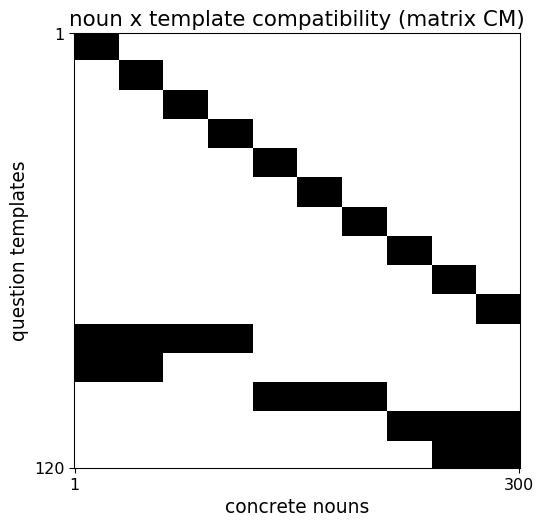

Figure 5B:


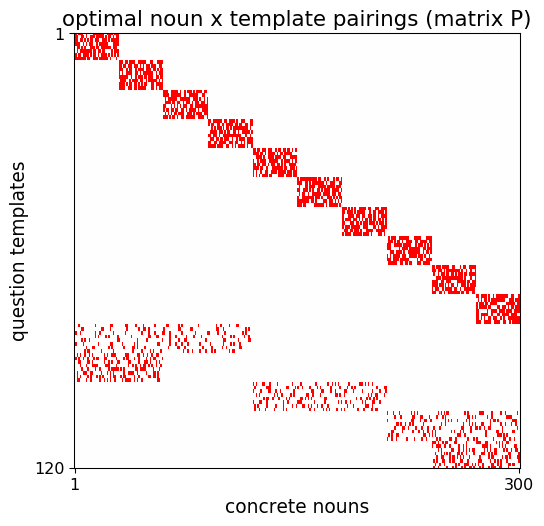

Figure 5C:



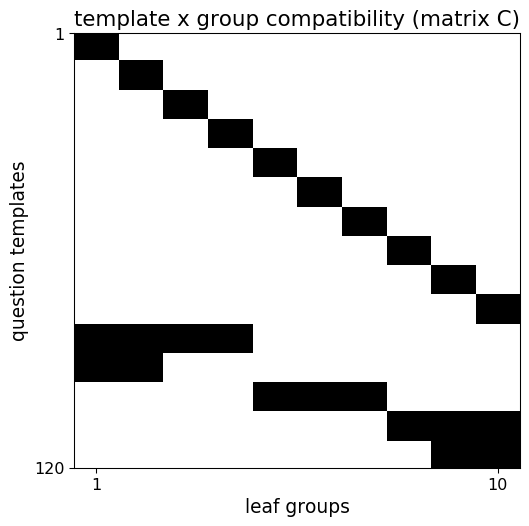

Figure 5D:


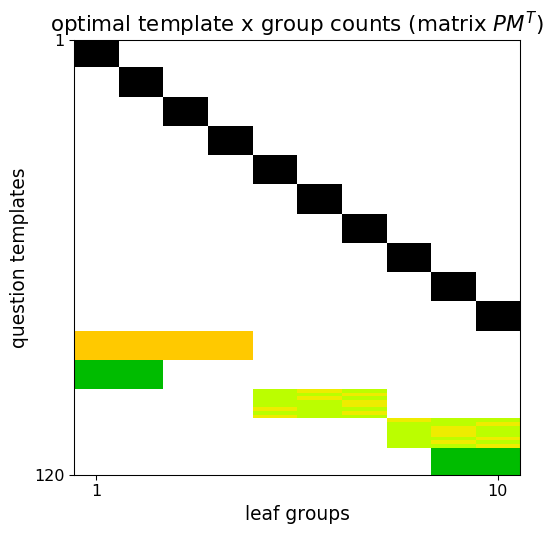

Figure 5D:


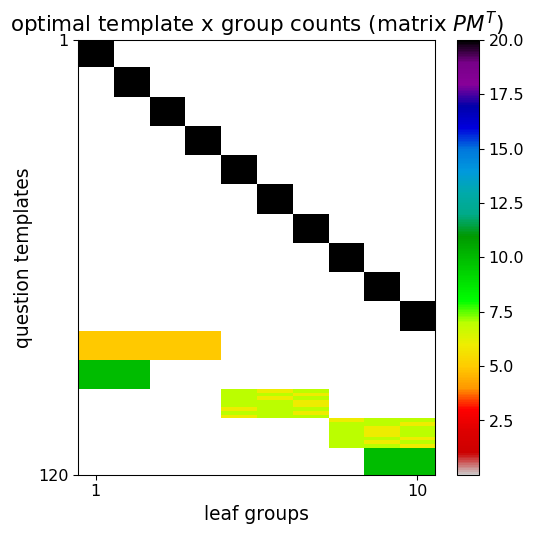

Figure 5E:


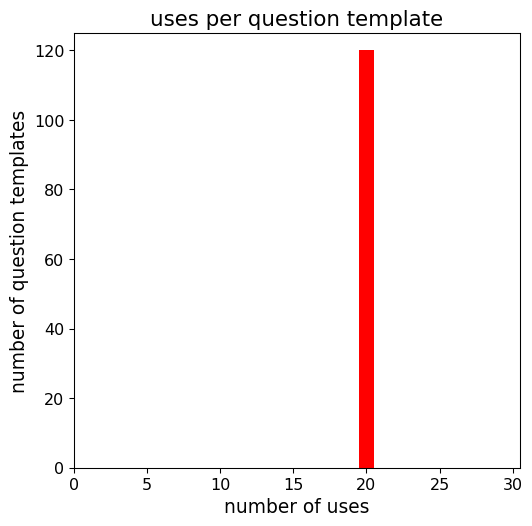

Figure 5F:


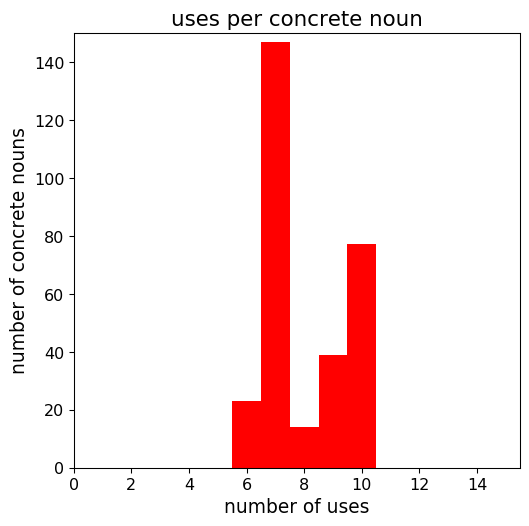

In [18]:
structured_sampling.plot_solution_summary_as_separate_figures(
    C,
    M,
    P,
    figsize=[6, 6],
    show_title=True,
    show_labels=True,
)

# Example Problem 4: Sequence Design For Navigation

Our final case study will demonstrate how MILP can address challenges associated with designing navigation experiments. Navigation is a rapidly advancing field of neuroscience featuring studies that are increasingly rich and naturalistic (Spiers and Maguire 2006; Suthana et al. 2011; Nielson et al. 2015). As these studies grow more complex, so do the design constraints that must be integrated into experimental designs. Here we show how MILP is a natural fit for representing and optimizing the structure of such experiments.

Suppose a researcher is designing a neuroimaging experiment where subjects must navigate a complex, naturalistic environment. Subjects will perform a “taxi driver” task where they are successively cued to drive to various locations on a map. Each time they reach a destination, a new destination cue will appear. Subjects will perform many of these trials throughout the course of the experiment.

An important aspect of this design is the sequence of cued destinations. This sequence will determine the particular distribution of navigational phenomena that the subject encounters throughout the experiment (Hartley et al. 2003; Xu et al. 2010). In the simplest case, this sequence could be generated randomly. However, this misses an opportunity to control the conditions measured by the experiment. Optimal selection of this sequence might require special consideration of the particular map being used and the hypotheses being tested.

### Design Specifications

For this example, suppose a map has 25 possible destinations. The researcher would like to collect 80 trials per subject over the course of 40 minutes, resulting in a mean trial time of 30 seconds. To prevent memory effects related to the lengths of trials, the researcher would like path lengths of each trial to approximate an exponential distribution. To prevent memory effects related to repeatedly visiting locations, the researcher would like the number of times each location is visited to assume a geometric distribution.

### MILP formulation

We will formulate this as a graph traversal problem where each location is a node and each route between locations is edge. This is similar to the classic traveling salesman problem, where the goal is to find a sequence that both visits every node once and minimizes total distance traveled. However, the goal here is instead to find a sequence whose edge length distribution maximally conforms to the target exponential distribution. Another difference is we would like to allow each destination to be visited more than once.

We will use notation $N_i$ to refer to node $i$, and $E_{i,j}$ to refer to the edge that connects $N_i$ to $N_j$. For simplicity, we will first formulate the problem where each node is visited at most once. Also for simplicity, we will randomly choose nodes $N_I$ and $N_F$ to be the initial and final nodes in the sequence. Introduce a binary variable to track the edges are used in the sequence

> **VARIABLES**
$$X \in \mathbb{B}^{25 \times 25} \\$$
$$\begin{aligned}
X_{i,j} &= 0 \text{ if edge } E_{i,j} \text{ is not used} \\
        &= 1 \text{ if edge } E_{i,j} \text{ is used}
\end{aligned}$$

Assume $X_{i,j} = 0$ for all $i$. We can constrain the number of edges in the sequence to equal the number of trials

> **CONSTRAINTS**
$$\sum_{i,j} X_{i,j} = \text{number of trials}$$

The number of times the subject enters and leaves each destination are given by the sums

> $$\sum_i X_{i,j} = \text{ number of times entering } N_j$$
$$\sum_j X_{i,j} = \text{ number of times entering } N_i$$

For a well formed sequence, $N_I$ should be left once, $N_F$ should be entered once

> **CONSTRAINTS**
$$\begin{aligned}
\sum_i X_{i, F} &= 1 \\
\sum_j X_{F, j} &= 0 \\
\sum_j X_{I, j} &= 1 \\
\sum_i X_{i, I} &= 0 \\
\end{aligned}$$


Other nodes should be entered and left an equal number of times

> **CONSTRAINTS**
$$\sum_i X_{i,h} = \sum_j X_{h,j} \quad \quad \quad \quad \forall \ h \notin \{ I, F \}$$

To constrain trial length so that it is distributed exponentially, we will discretize exponential distribution into a 10 bin histogram, as shown in **Figure 6C**. Each bin represents a specific range of trial lengths $R_b$ and has a target number of trials $T_b$ that should fall in that range.

Let $L_{i,j}$ be the length of edge $E_{i,j}$. Let Ab be the number of trials that fall within the range of bin $b$. Our cost function is then the deviation between the actual and target number of trials within each bin

> **COST FUNCTION**
$$B_b = \left \{ (i,j) | L_{i,j} \in R_b \right \} \\$$
$$A_b = \sum_{ (i,j) \in B_b} X_{i,j}$$
$$\min \sum_b | T_b - A_b |$$

These constraints produce a sequence that is formed from NI to NF. However, they also allow for the inclusion of “subtours”, which are additional unconnected cyclic paths that exist alongside the main sequence. Since we want a single, acyclic sequence, we will utilize a common technique called “subtour elimination”. Eliminating all subtours outright would require an intractably large number of constraints. Much more efficient is to iteratively solve a series of MILP programs, and successively add constraints until a solution free of subtours is found. Details of subtour elimination and iterative solving can be found in (Laporte and Nobert 1983). For each subtour detected in the intermediate solutions, we will add a constraint

> **CONSTRAINT**
$$S = \text{ the set of edges in subtour} \\$$
$$\sum_{(i,j) \in S , i \neq j} X_{i, j} \leq |S| - 1$$

Finally, to allow each node to be visited multiple times, we will simply stack multiple copies of the original graph. Each node will be connected to all copies of all nodes other than itself. Any route through this augmented graph can be transformed into a route on the original graph by simply combining all copies of each node into a single node.


n_trials: 80.0
mean_repeats_per_node: 3.2
mean_trial_distance: 0.25
Figure 6D:


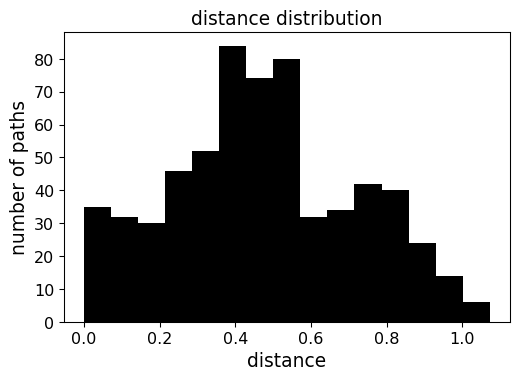

In [19]:
np.random.seed(0)

n_nodes = 25

x = np.random.rand(n_nodes)
y = np.random.rand(n_nodes)
distances = ((x - x[:, np.newaxis]) ** 2 + (y - y[:, np.newaxis]) ** 2) ** 0.5

t_per_distance = 2.0
t_mean_trial = 0.5

t_per_run = 10.0
n_runs = 4
n_trials = (n_runs * t_per_run) / float(t_mean_trial)
# n_trials = 100

mean_repeats_per_node = n_trials / float(n_nodes)
mean_trial_distance = t_mean_trial / t_per_distance

print('n_trials:', n_trials)
print('mean_repeats_per_node:', mean_repeats_per_node)
print('mean_trial_distance:', mean_trial_distance)


trajectory_design.plot_distance_distribution(distances)

### repeats per node

compute repeats per node

mean 3.199385156983983

count sum: 25
weighted count sum: 80


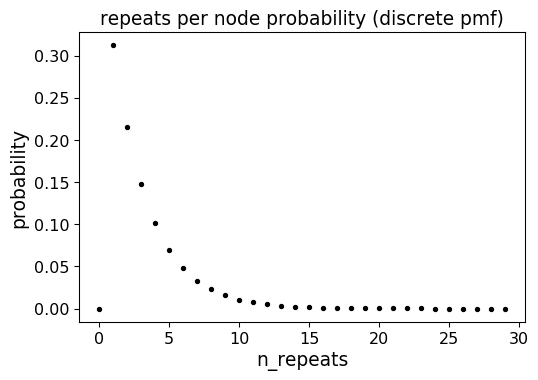

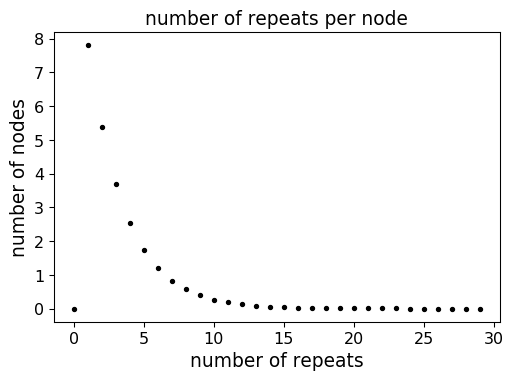

Figure 6C:


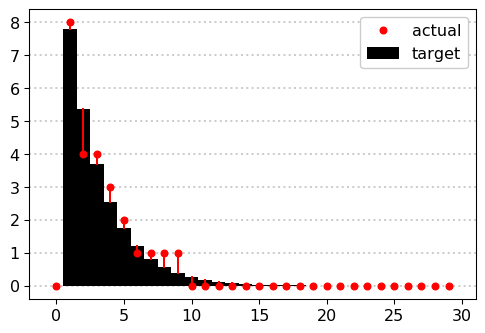

/home/jlg/storm/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


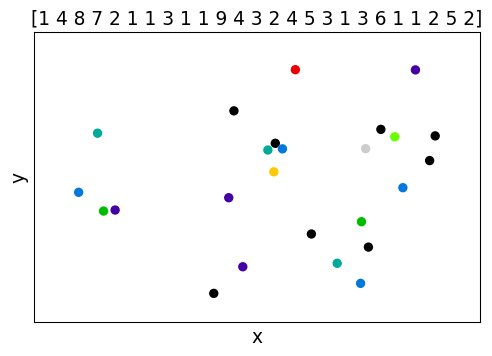

In [20]:
print('compute repeats per node')
print()

n_counts = 30
geometric_parameter = 1 / mean_repeats_per_node

n_repeats = np.arange(n_counts)
n_repeats_pmf = scipy.stats.geom.pmf(n_repeats, geometric_parameter)

repeat_counts = trajectory_design.compute_repeats(n_counts, n_nodes, n_trials)
visits_per_location = trajectory_design.compute_visits_per_location(
    repeat_counts
)

print('mean', (n_repeats_pmf * n_repeats).sum())
print()
print('count sum:', repeat_counts.sum())
print(
    'weighted count sum:',
    (repeat_counts * np.arange(repeat_counts.shape[0])).sum(),
)

trajectory_design.plot_node_repeats_pmf(n_repeats, n_repeats_pmf)
plt.show()
trajectory_design.plot_node_repeats_denormalized(
    n_repeats,
    n_repeats_pmf,
    n_nodes,
)
plt.show()
trajectory_design.plot_target_vs_actual_repeats_per_node(
    repeat_counts,
    n_repeats_pmf,
    n_nodes,
)
plt.show()
trajectory_design.plot_locations(
    x,
    y,
    colors=visits_per_location,
    title=visits_per_location,
    cmap='nipy_spectral',
)
plt.show()

### path length distribution

program size:
- n_variables: 20
- n_constraints: 21
- n_cost_function_terms: 10
target mean: 0.25
mean: 0.25


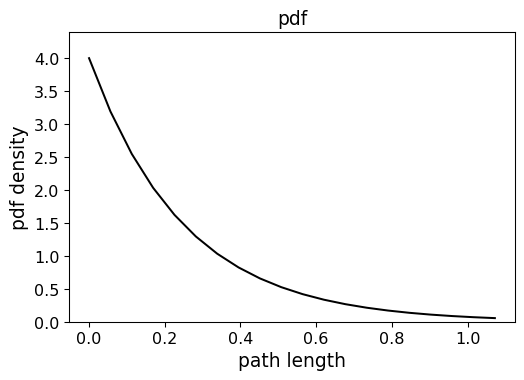

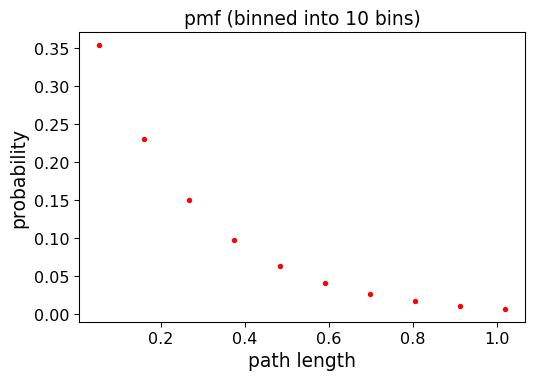

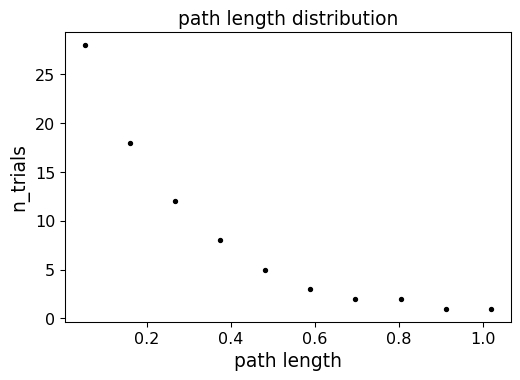

In [21]:
n_bins = 10

distance_pdf = trajectory_design.compute_target_path_length_pdf(
    distances,
    mean_trial_distance,
)
distance_pmf = trajectory_design.compute_target_path_length_pmf(
    n_bins,
    distances,
    distance_pdf,
)
discrete_path_distribution = trajectory_design.compute_target_path_length_discrete(
    distance_pmf,
    n_trials,
)

print('target mean:', mean_trial_distance)
print('mean:', distance_pdf['scipy_distribution'].mean())

trajectory_design.plot_distance_pdf(distance_pdf)
plt.show()
trajectory_design.plot_distance_pmf(distance_pmf)
plt.show()
trajectory_design.plot_discrete_path_distribution(discrete_path_distribution)
plt.show()

### compute path

In [22]:
trajectory = trajectory_design.compute_trajectory(
    visits_per_location=visits_per_location,
    distances=distances,
    target_path_length_distribution=discrete_path_distribution,
)

program size:
- n_variables: 6170
- n_constraints: 182
- n_cost_function_terms: 10

    eliminating subtours iteration 0 (sizes = [11, 41, 3, 17, 9, 3, 3])
    eliminating subtours iteration 1 (sizes = [18, 60, 3, 3])
    eliminating subtours iteration 2 (sizes = [76, 4, 3])
    eliminating subtours iteration 3 (sizes = [54, 12, 4, 3, 3, 3, 3, 3, 4])
    eliminating subtours iteration 4 (sizes = [71, 7, 5])
    eliminating subtours iteration 5 (sizes = [22, 9, 37, 10, 3, 3, 3])
    eliminating subtours iteration 6 (sizes = [26, 29, 5, 3, 3, 17, 4])
    eliminating subtours iteration 7 (sizes = [48, 12, 21, 3])
    eliminating subtours iteration 8 (sizes = [52, 23, 3, 3, 4])
    eliminating subtours iteration 9 (sizes = [34, 41, 4, 3, 3])
    eliminating subtours iteration 10 (sizes = [45, 5, 25, 3, 5, 3])
    eliminating subtours iteration 11 (sizes = [17, 40, 9, 4, 13, 3])
    eliminating subtours iteration 12 (sizes = [13, 52, 8, 3, 7, 3])
    eliminating subtours iteration 13 (sizes

### compute random paths

In [23]:
n_random = 10000000
# n_random = 100000

random_paths = trajectory_design.compute_random_paths(
    n_random=n_random,
    n_trials=n_trials,
    distances=distances,
    visits_per_location=visits_per_location,
    **discrete_path_distribution
)

for key, value in random_paths.items():
    print(key + ':', value)

best_path: [19 16 15 14 19 15 15  7 14  2  5  1 21 13 19  8 23 24 13 19  7 14  1 18
  1  2  2  3 23  7 14  0 23  3 10 16 23  2  9 10 12 11  3 12 22  1 18 15
 24 10  3  3 11  2  4 23 10  2 20 10 15 16 19 17 19 10 19 10 10  2  2  6
 11 10  3 22 11  4 18 12  3]
best_counts: [21  7 14  8  5  3  7 11  3  1]
best_error: 36
n_random: 10000000


### Plot Results

Figure 6D:


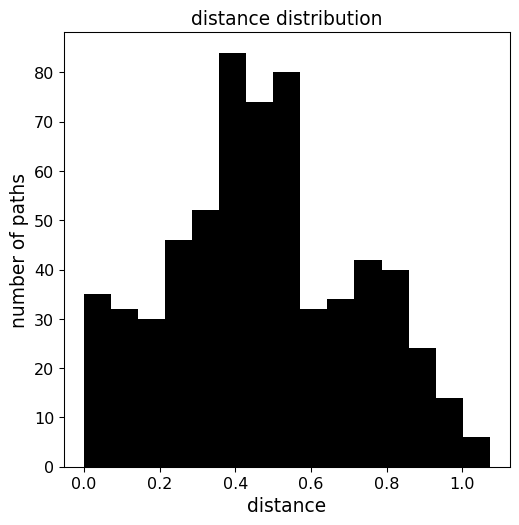

Figure 6C:


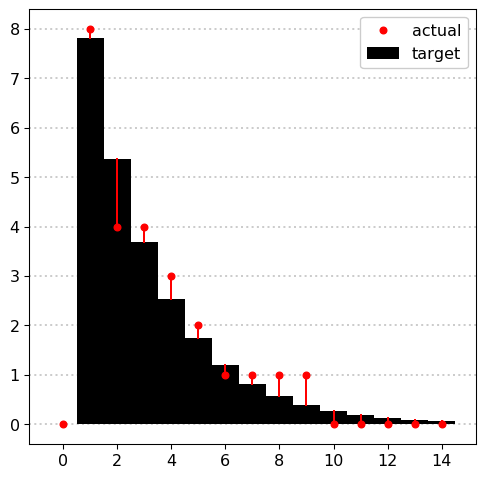

Figure 6E:


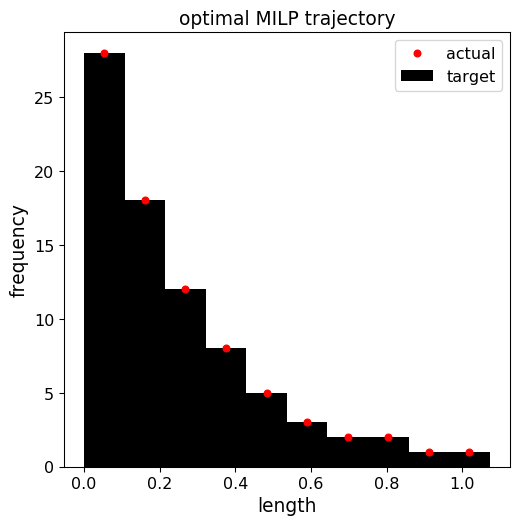

Figure 6F:


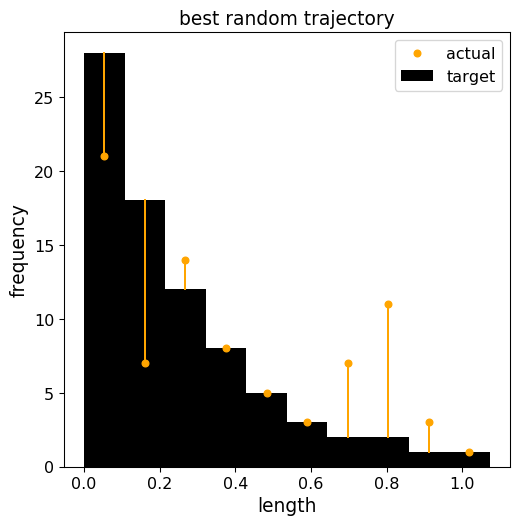

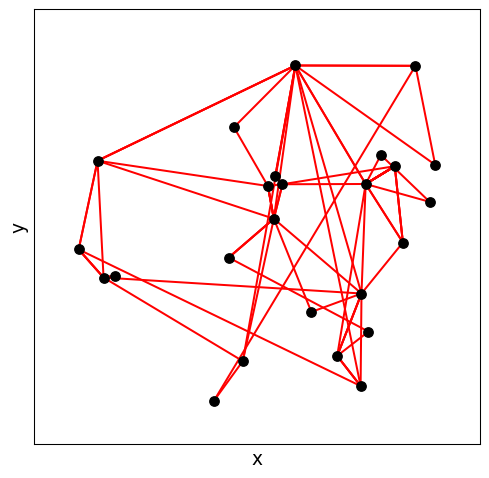

In [24]:
figsize = [6, 6]
n_shown_repeats = 15

trajectory_design.plot_summary(
    distances=distances,
    n_repeats=n_repeats,
    n_repeats_pmf=n_repeats_pmf,
    n_nodes=n_nodes,
    repeat_counts=repeat_counts,
    n_shown_repeats=n_shown_repeats,
    x=x,
    y=y,
    visits_per_location=visits_per_location,
    distance_pdf=distance_pdf,
    discrete_path_distribution=discrete_path_distribution,
    distance_pmf=distance_pmf,
    trajectory=trajectory,
    random_paths=random_paths,
    figsize=figsize,
    show_title=True,
    show_labels=True,
    show_legend=True,
    show_colorbar=True,
)

A solution to the problem as found by MILP is shown in **Figure 6**. Each location on the map is represented by a black dot (**Figure 6A**). The optimal sequence is shown by the red lines. Within this sequence, the target distribution and actual distribution of path lengths are shown in **Figure 6E**. The distribution of trial lengths exactly conforms to the target distribution. If it were not possible to exactly achieve this distribution, the MILP solver would find a sequence that conforms to this distribution as closely as possible. For comparison, we also generated 10^7 random paths through the map, and we show the path length histogram for the random path that best conforms to the target distribution (**Figure 6F**). Unlike the solution found using MILP, the best randomized solution has substantial deviations from the target distribution. This shows that simple algorithms are not well-equipped to search this highly structured space, and that a more sophisticated framework such as MILP is needed to find optimal points.

Incorporating these diverse constraints would not be possible with traditional methods. Here MILP integrated structural constraints imposed by the map, time constraints imposed by data collection logistics, and behavioral constraints imposed by memory effects. Each design parameter can also be tweaked as needed in a flexible and explicit manner. For example, rather than simply controlling the trial length distribution, the researcher could control many other properties of the experiment by changing the nodes, edges, and other values associated with the graph structure.